In [1]:
!pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ------ --------------------------------- 0.5/3.0 MB 1.5 MB/s eta 0:00:02
     ---------- ----------------------------- 0.8/3.0 MB 1.7 MB/s eta 0:00:02
     ------------- -------------------------- 1.0/3.0 MB 1.6 MB/s eta 0:00:02
     ------------- -------------------------- 1.0/3.0 MB 1.6 MB/s eta 0:00:02
     ----------------- ---------------------- 1.3/3.0 MB 1.0 MB/s eta 0:00:02
     -------------------- ------------------- 1.6/3.0 MB 1.0 MB/s eta 0:00:02
     ------------------------ --------------- 1.8/3.0 MB 1.1 MB/s eta 0:00:02
     --------------------------- ------------ 2.1/3.0 MB 1.1 MB/s eta 0:00:01
     ---------------------------------- ----- 2.6/3.0 MB 1.2 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 1.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: fini

In [8]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
ticker = 'PETR4.SA'  # Ação da Petrobras, por exemplo
dados = yf.download(ticker, start='2022-01-01', end='2023-12-31')

[*********************100%***********************]  1 of 1 completed


In [27]:
print(dados.head())

Price           Close       High        Low       Open    Volume
Ticker       PETR4.SA   PETR4.SA   PETR4.SA   PETR4.SA  PETR4.SA
Date                                                            
2022-01-03  14.259786  14.323511  13.985276  13.990179  52704700
2022-01-04  14.313704  14.411743  14.171547  14.294096  51739200
2022-01-05  13.759786  14.348021  13.696061  14.308805  78459800
2022-01-06  13.749978  14.044095  13.647037  13.867626  61163100
2022-01-07  13.813704  13.867626  13.637234  13.779391  47507600


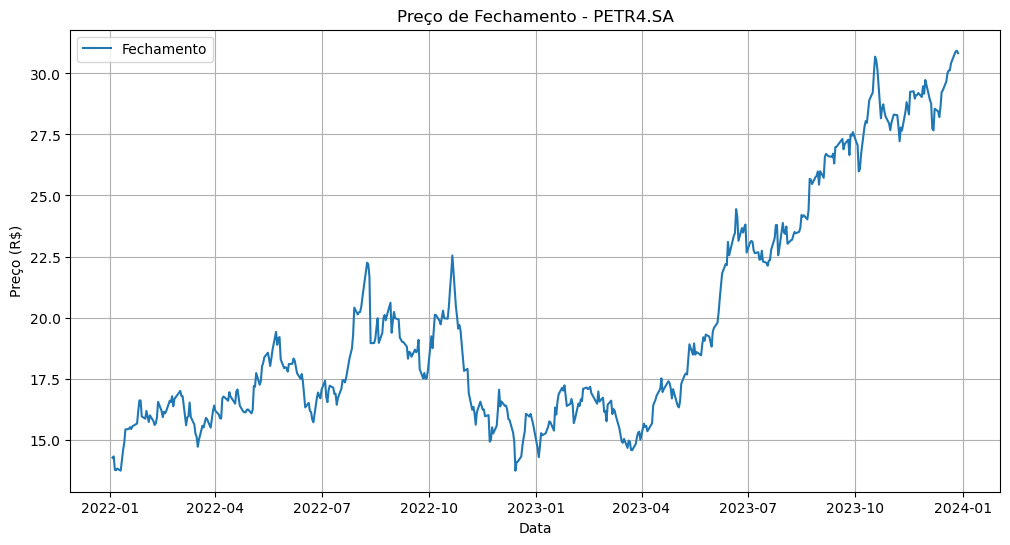

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(dados['Close'], label='Fechamento')
plt.title(f'Preço de Fechamento - {ticker}')
plt.xlabel('Data')
plt.ylabel('Preço (R$)')
plt.legend()
plt.grid()
plt.show()

In [29]:
# Calculando as médias móveis
dados['MM9'] = dados['Close'].rolling(window=9).mean()
dados['MM21'] = dados['Close'].rolling(window=21).mean()

In [40]:
# Criando os sinais de compra e venda
dados['Sinal'] = 0  # Inicializa tudo com 0
# dados['Sinal'][9:] = np.where(dados['MM9'][9:] > dados['MM21'][9:], 1, 0)
dados['Sinal'] = 0
dados.loc[dados.index[9:], 'Sinal'] = np.where(
    dados.loc[dados.index[9:], 'MM9'] > dados.loc[dados.index[9:], 'MM21'],
    1, 0
)

In [41]:
# Gera posição (mantém a posição até o sinal mudar)
dados['Posição'] = dados['Sinal'].diff()

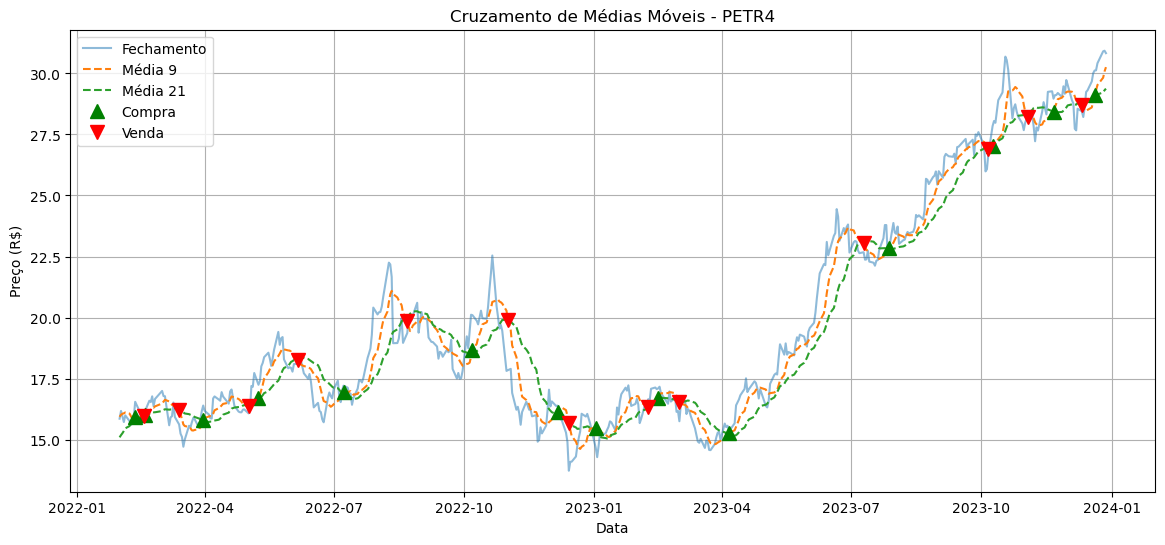

In [42]:
# Visualizando as posições no gráfico
plt.figure(figsize=(14, 6))
plt.plot(dados['Close'], label='Fechamento', alpha=0.5)
plt.plot(dados['MM9'], label='Média 9', linestyle='--')
plt.plot(dados['MM21'], label='Média 21', linestyle='--')

# Marcando os sinais no gráfico
plt.plot(dados[dados['Posição'] == 1].index, dados['MM9'][dados['Posição'] == 1], '^', markersize=10, color='g', label='Compra')
plt.plot(dados[dados['Posição'] == -1].index, dados['MM9'][dados['Posição'] == -1], 'v', markersize=10, color='r', label='Venda')

plt.title('Cruzamento de Médias Móveis - PETR4')
plt.xlabel('Data')
plt.ylabel('Preço (R$)')
plt.legend()
plt.grid()
plt.show()

In [43]:
# Garantindo que a coluna de sinais está sem valores nulos
dados = dados.dropna()

In [44]:
# Criando DataFrame apenas com os pontos de entrada e saída
entradas = dados[dados['Posição'] == 1]
saidas = dados[dados['Posição'] == -1]

In [45]:
# Garantir que cada entrada tenha uma saída posterior
entradas = entradas[:len(saidas)]

In [46]:
# Resetar o índice para operar mais facilmente
entradas = entradas.reset_index()
saidas = saidas.reset_index()

In [47]:
# Calculando os retornos por operação
resultados = pd.DataFrame()
resultados['Entrada'] = entradas['Close']
resultados['Saída'] = saidas['Close']
resultados['Data_Entrada'] = entradas['Date']
resultados['Data_Saída'] = saidas['Date']
resultados['Retorno (%)'] = (resultados['Saída'] - resultados['Entrada']) / resultados['Entrada'] * 100

In [48]:
# Estatísticas do backtest
lucro_total = resultados['Retorno (%)'].sum()
media_retorno = resultados['Retorno (%)'].mean()
acertos = resultados[resultados['Retorno (%)'] > 0].shape[0]
erros = resultados[resultado := resultados['Retorno (%)'] <= 0].shape[0]
taxa_acerto = acertos / len(resultados) * 100

In [49]:
# Mostrando os resultados
print(resultados)
print(f"\n📈 Lucro total: {lucro_total:.2f}%")
print(f"📊 Retorno médio por trade: {media_retorno:.2f}%")
print(f"✅ Taxa de acerto: {taxa_acerto:.2f}% ({acertos} acertos, {erros} erros)")

      Entrada      Saída Data_Entrada Data_Saída  Retorno (%)
0   16.548996  16.078409   2022-02-11 2022-02-17    -2.843597
1   16.176449  15.622525   2022-02-18 2022-03-14    -3.424260
2   16.397036  16.077427   2022-03-31 2022-05-02    -1.949186
3   17.246500  18.107553   2022-05-09 2022-06-06     4.992627
4   17.211140  19.368509   2022-07-08 2022-08-22    12.534728
5   20.097593  17.844608   2022-10-07 2022-11-01   -11.210223
6   16.393154  13.727027   2022-12-06 2022-12-14   -16.263662
7   14.654096  16.655291   2023-01-02 2023-02-08    13.656216
8   17.096445  15.753796   2023-02-15 2023-03-02    -7.853384
9   15.344605  22.676008   2023-04-06 2023-07-10    47.778373
10  22.837158  26.695036   2023-07-28 2023-10-06    16.892985
11  27.842184  28.312197   2023-10-09 2023-11-03     1.688131
12  28.965431  28.444916   2023-11-21 2023-12-11    -1.797023

📈 Lucro total: 52.20%
📊 Retorno médio por trade: 4.02%
✅ Taxa de acerto: 46.15% (6 acertos, 7 erros)


In [50]:
# Simulação de capital ao longo do tempo
capital_inicial = 10000  # pode mudar o valor inicial
capital = [capital_inicial]

In [51]:
for retorno in resultados['Retorno (%)']:
    novo_valor = capital[-1] * (1 + retorno / 100)
    capital.append(novo_valor)

In [52]:
# Remover o primeiro capital (inicial) da lista de comparação
capital = capital[1:]
resultados['Capital'] = capital

In [53]:
# Cálculo de drawdown
resultados['Pico'] = resultados['Capital'].cummax()
resultados['Drawdown (%)'] = (resultados['Capital'] - resultados['Pico']) / resultados['Pico'] * 100
drawdown_maximo = resultados['Drawdown (%)'].min()

In [54]:
# Expectativa matemática
expectativa = (resultados['Retorno (%)'].mean() / 100) * (acertos / len(resultados)) + \
              (resultados['Retorno (%)'].mean() / 100) * (erros / len(resultados))

In [55]:
# Mostrar os resultados
print(f"💼 Capital final: R$ {capital[-1]:.2f}")
print(f"📉 Drawdown máximo: {drawdown_maximo:.2f}%")
print(f"📐 Expectativa matemática (por trade): {expectativa:.4f}")

💼 Capital final: R$ 14600.91
📉 Drawdown máximo: -25.65%
📐 Expectativa matemática (por trade): 0.0402


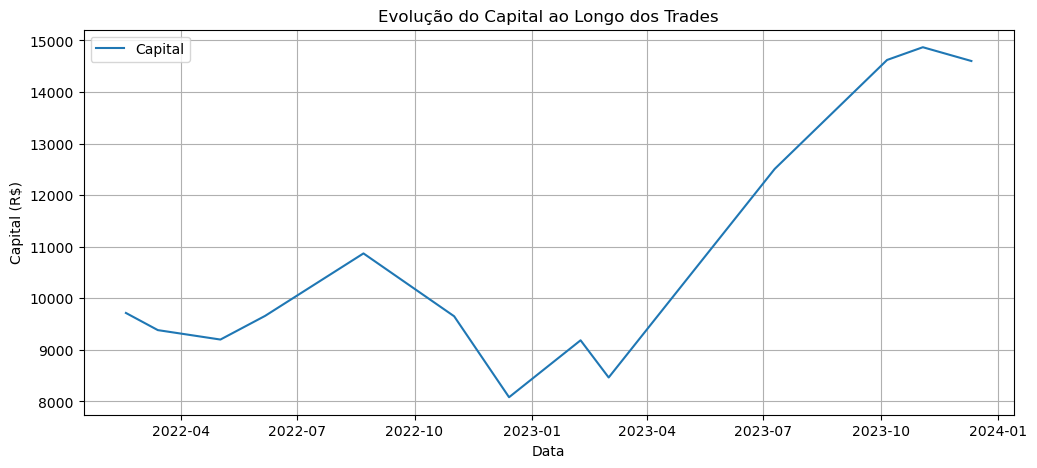

In [56]:
# Plotando a evolução do capital
plt.figure(figsize=(12, 5))
plt.plot(resultados['Data_Saída'], resultados['Capital'], label='Capital')
plt.title('Evolução do Capital ao Longo dos Trades')
plt.xlabel('Data')
plt.ylabel('Capital (R$)')
plt.grid()
plt.legend()
plt.show()